## Objective: 
1. Choosing the model with best performance, highest F1 and ROC-AUC score. <br>
2. Finetune said model hyperparameters.
<br/>

<em>EDA.ipynb contains info about data processing, cleaning, feature selection, etc.</em>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline


In [2]:
# Removing unwanted warnings
import warnings
warnings.filterwarnings('ignore')

### Importing cleaned data 

In [3]:
results = [] # FOR STORING MODEL METRICS FOR SMOTE
# results_enn = [] # FOR STORING MODEL METRICS FOR SMOTEENN
df = pd.read_csv('cleaned_data.csv')
df.shape

(32416, 23)

### Split the data into features and target variable

Variables to be choosen during EDA by correlation  matrix

In [4]:

features = ['loan_percent_income', 'loan_int_rate',
'loan_grade_D',
'loan_grade_E',
'loan_grade_F',
'loan_grade_G',
'loan_amnt',
'person_home_ownership_RENT',
'person_home_ownership_OWN',
'person_income',
'person_emp_length']
target = ['loan_status']
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df['loan_status'])

### Creating a pipeline
Scaler -> Oversampling (SMOTE) -> Model 
<br>
<br>
The oversampling is required as the target variable data points are unbalanced.

In [5]:
# Scaler 
Scaler = StandardScaler()

In [6]:
# SMOTE
smote = SMOTE(random_state=42)
smote_enn = SMOTEENN(random_state=42)

### Models used for classification:
- Logestic Regression
- Random Forest
- XGBoost
- SVM
- KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

In [8]:
# Base Classification Models
basic_models= {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance'),
}

In [9]:
advanced_models_1 = {
    "SVM(fast & linear)": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42),
    # "SVM (RBF small)": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42, max_iter=1000), # dropped as it is slow and overfitting to the data
    "XGBoost": XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1             # use all CPU cores
)}
advanced_models_2 = {
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42),
}

### Implementing the pipeline


In [10]:
def evaluate_model(models, smote_type=smote, results_dict=results):
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('scaler', Scaler),
            ('smote', smote_type),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        # metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, output_dict=True)
        results_dict.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1,
            'ROC_AUC': auc
        })
    return report


### USING SMOTE 

In [11]:
report = evaluate_model(basic_models)
print("=== Basic Models Evaluation Complete ===")
print("Classification report for base models:\n",pd.DataFrame(report))
report = evaluate_model(advanced_models_1)
print("=== Advanced Models 1 Evaluation Complete ===")
print("Classification report for Advanced Models 1:\n",pd.DataFrame(report))
report = evaluate_model(advanced_models_2)
print("=== Advanced Models 2 Evaluation Complete ===")
print("Classification report for Advanced Models 2:\n",pd.DataFrame(report))

=== Basic Models Evaluation Complete ===
Classification report for base models:
                      0            1  accuracy    macro avg  weighted avg
precision     0.926607     0.609909  0.840839     0.768258      0.857348
recall        0.864785     0.755289  0.840839     0.810037      0.840839
f1-score      0.894629     0.674858  0.840839     0.784744      0.846567
support    5066.000000  1418.000000  0.840839  6484.000000   6484.000000
=== Advanced Models 1 Evaluation Complete ===
Classification report for Advanced Models 1:
                      0            1  accuracy    macro avg  weighted avg
precision     0.960591     0.481919  0.766656     0.721255      0.855909
recall        0.731346     0.892807  0.766656     0.812076      0.766656
f1-score      0.830438     0.625958  0.766656     0.728198      0.785720
support    5066.000000  1418.000000  0.766656  6484.000000   6484.000000
[LightGBM] [Info] Number of positive: 20261, number of negative: 20261
[LightGBM] [Info] Auto-cho

In [13]:
# Metrics / Results 
results_df = pd.DataFrame(results).sort_values(by='ROC_AUC', ascending=True)
print("\n===== SMOTE Metrics =====")
print(results_df)


===== SMOTE Metrics =====
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
3   SVM(fast & linear)  0.826804   0.580207  0.752468  0.655204  0.859275
0  Logistic Regression  0.818168   0.561503  0.769394  0.649212  0.863009
2                  KNN  0.840839   0.609909  0.755289  0.674858  0.874945
7          Extra Trees  0.894047   0.775849  0.724965  0.749544  0.911280
1        Random Forest  0.900524   0.798917  0.728491  0.762080  0.917467
6    Gradient Boosting  0.895743   0.772794  0.741185  0.756659  0.918092
4              XGBoost  0.766656   0.481919  0.892807  0.625958  0.921220
5             LightGBM  0.907156   0.842857  0.707334  0.769172  0.928677


### USING SMOTENN

In [14]:
result_enn = [] # FOR STORING MODEL METRICS FOR SMOTEENN
report = evaluate_model(basic_models, smote_type=smote_enn, results_dict=result_enn)
print("=== Basic Models Evaluation Complete ===")
print("Classification report for base models:\n",pd.DataFrame(report))
report = evaluate_model(advanced_models_1, smote_type=smote_enn, results_dict=result_enn)
print("=== Advanced Models 1 Evaluation Complete ===")
print("Classification report for Advanced Models 1:\n",pd.DataFrame(report))
report = evaluate_model(advanced_models_2, smote_type=smote_enn, results_dict=result_enn)
print("=== Advanced Models 2 Evaluation Complete ===")
print("Classification report for Advanced Models 2:\n",pd.DataFrame(report))

=== Basic Models Evaluation Complete ===
Classification report for base models:
                      0            1  accuracy    macro avg  weighted avg
precision     0.934500     0.555775  0.816163     0.745137      0.851676
recall        0.822345     0.794076  0.816163     0.808211      0.816163
f1-score      0.874843     0.653891  0.816163     0.764367      0.826522
support    5066.000000  1418.000000  0.816163  6484.000000   6484.000000
=== Advanced Models 1 Evaluation Complete ===
Classification report for Advanced Models 1:
                      0            1  accuracy    macro avg  weighted avg
precision     0.955216     0.498191   0.77992     0.726704      0.855268
recall        0.753652     0.873766   0.77992     0.813709      0.779920
f1-score      0.842547     0.634571   0.77992     0.738559      0.797064
support    5066.000000  1418.000000   0.77992  6484.000000   6484.000000
[LightGBM] [Info] Number of positive: 17179, number of negative: 14631
[LightGBM] [Info] Auto-cho

In [15]:
# Metrics / Results 
results_df = pd.DataFrame(result_enn).sort_values(by='ROC_AUC', ascending=True)
print("\n===== SMOTENN Metrics =====")
print(results_df)


===== SMOTENN Metrics =====
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
2                  KNN  0.816163   0.555775  0.794076  0.653891  0.852659
3   SVM(fast & linear)  0.825571   0.577109  0.757405  0.655078  0.859679
0  Logistic Regression  0.811690   0.549622  0.769394  0.641199  0.861536
7          Extra Trees  0.873535   0.689721  0.766573  0.726119  0.900855
1        Random Forest  0.879087   0.701654  0.777856  0.737793  0.906966
6    Gradient Boosting  0.870296   0.678196  0.774330  0.723082  0.908505
4              XGBoost  0.779920   0.498191  0.873766  0.634571  0.908807
5             LightGBM  0.880938   0.713907  0.760226  0.736339  0.916092


## Interpretation 
### SMOTE vs SMOTE-ENN 
- SMOTE-ENN is faster (Overlapping class boundaries, outliers, and noisy data points are removed as a result reducing total points and making classification easier)
- SMOTE performs marginally better than SMOTENN and leads to better F1.
Result - SMOTE will be used. 
### Model Metrics:
- Linear models : Both Logestic regression and linear SVM performed well. 
<br>
- Clustering : Performs decently but leads to high number of false positives as shown by low F1 and precision. 
<br>
- SVM (RBF) : Performs poorly and is unable to converge (excluded).
<br>
- Ensembling models : LightGBM / RandomForest and perform well with acceptable F1, precision and ROC-AUC.<br>
Best-performer - LGBM : Since LightGBM has highest AUC and most balanced F1. 
<br>
## <em>LGBM</em> will be used for finetuned the model for lower F1.

### Hyperparameters tuning
Using cross-validation grid search to find the hyper-params that give the lowest F1 Score.

In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:

param_grid = {
    'num_leaves': [15, 24,31, 63],
    'max_depth': [-1, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [19]:

lgbm = LGBMClassifier(class_weight='balanced', n_jobs=-1)


search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',        #optimize F1
    cv=5,                #5fold crossvalidation
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best F1:", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 5671, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 25932, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best params: {'subsample': 1.0, 'num_leaves': 24, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best F1: 0.7574704612458305


### Evaluating "best" model performance

In [26]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import lightgbm as lgb

In [21]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report for Best Model after Hyperparameter Tuning:\n")
print(classification_report(y_test, y_pred))
print("=== Confusion matrix ===")
print(confusion_matrix(y_test, y_pred))

Classification Report for Best Model after Hyperparameter Tuning:

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5066
           1       0.75      0.78      0.77      1418

    accuracy                           0.90      6484
   macro avg       0.84      0.86      0.85      6484
weighted avg       0.90      0.90      0.90      6484

=== Confusion matrix ===
[[4696  370]
 [ 305 1113]]


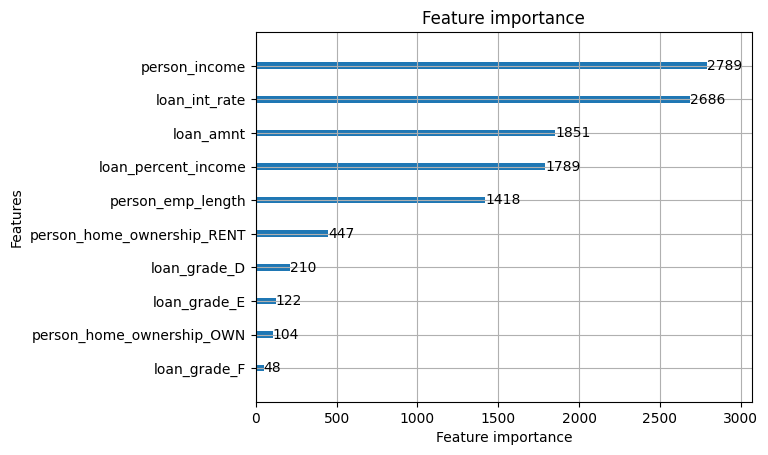

In [24]:
lgb.plot_importance(best_model, max_num_features=10)
plt.show()

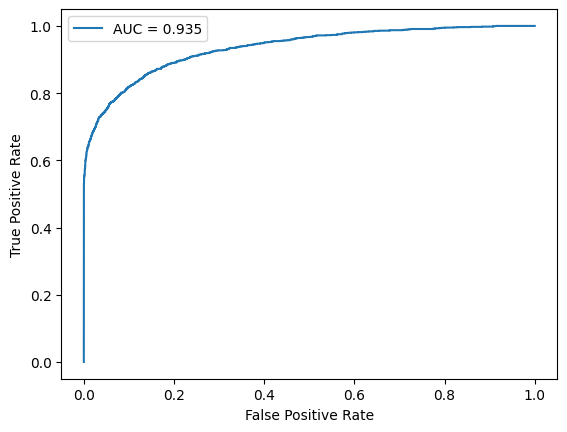

In [27]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Classification report
- High precision (0.75) - minimizing false approvals, which is crucial in credit risk analysis. (Highest of all other models)
- Recall of 0.78 means it identifies 78% of actual risky borrowers
- Overall accuracy of 90% and F1-score of 0.77 for the high-risk class show a strong trade-off between precision and recall, reflecting a robust model for operational use
### Confusion matrix
- 1418 risky leaders - 1,113 were correctly identified (true positives), while 305 were missed
- 5,066 low-risk borrowers - 4,696 were correctly classified, with 370 falsely flagged as risky

## Conclusion : 
After testing multiple algorithms, LightGBM with tuned hyperparameters achieved the best performance.
It provides a robust, interpretable, and efficient model for credit risk prediction.
The tuned LightGBM model demostrates strong generalization and balanced performance on data.